Goal: 
Examine if the shophouse addresses from GFZ matches with the addresses from Tuebingen, if most adresses matches than update my dataset with the improved geolocations and furhter housing information for the respective shohouse addresses (such as the number of floors per building) 

In [179]:
import sys, os

import numpy as np
import pandas as pd
import geopandas as gpd
import re

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.insert(0, "../")
#sys.path.insert(0,os.getcwd())
import utils.utils_figures as f
from utils.utils_processing import drop_object_columns, drop_typos
import utils.utils_feature_selection as fs

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [180]:
# load survey data
raw_data = pd.read_excel("../../input_survey_data/all-attributes_shophouses.xlsx")  # Niveditas dataset
vietnamese_data = pd.read_excel("../../input_survey_data/Data DECIDER shophouse.xlsx")  # Dataset in vietnamese characters
vietnamese_data.head(3)


,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

In [273]:
vietnamese_data["street"] = vietnamese_data["Q0.3"].replace(to_replace=r"\d+|/|,|-", value="", regex=True)
vietnamese_data["street"] = vietnamese_data["street"].str.strip()

vietnamese_data["house_number"] = vietnamese_data["Q0.3"].replace(to_replace=r"([^0-9-/.]+)", value="", regex=True)
vietnamese_data.tail(3)

,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

In [274]:
geoinformations = gpd.read_file("../../input_survey_data/Buildings_HCMC/HCMC_buildings_survey_TUEB_addresses.shp")  # Dataset in vietnamese characters

## fix floor numbers. 10-->1, 20-->2
geoinformations.Nr_Floors = geoinformations.Nr_Floors.replace({10:1, 20:2, 30:3, 40:4}).astype("Int64") 

geoinformations.head(3)

,build_id,ImageName,Street,HouseNumbe,LMUAddress,Quest_ID,BT_Moon,Nr_Floors,BT_TUEB_2,geometry
0,1460.0,1689152242961.jpg,Lê Thành P,27,27 Lê Thàn,1461.0,Shop-New,2,Single / Two Family Local-Type Building,MULTIPOINT (106.62941 10.71748)
1,2003.0,1689132271718.jpg,Phú Định,231,231 Phú Đị,1448.0,Rudimental,1,Single Family Rudimentary / Basic or Unplanned...,MULTIPOINT (106.62891 10.72250)
2,1410.0,1689140728092.jpg,Phú Định,193/15,NaN,1410.0,Shop-Traditional,2,Single / Two Family Local-Type Building,MULTIPOINT (106.62936 10.72475)


In [275]:
## Fix erroneous coordinate pair by removing second decimal point
raw_data.GPS = raw_data.GPS.astype(str).replace({"10.722.546,106.62888":"10.722546,106.62888",
                                     "10797626106701100":"10.797626,106.701100",  # idx 24
                                     "10722187106.63":"10.722187,106.63"})  # idx 152

In [276]:
# get coords in readable format for gpd
raw_data = gpd.GeoDataFrame(raw_data,  
            geometry=gpd.points_from_xy( 
                    raw_data["GPS"].str.split(",").str[1], # lon
                    raw_data["GPS"].str.split(",").str[0],  # lat
            )
        )
print(raw_data.shape)

## save shp locations to disk, 
# extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
print(raw_data.crs)
raw_data = raw_data.set_crs(4326) 

(252, 551)
EPSG:4326


### Overview

In [277]:
## visual check of SMEs locations
import folium

glimpse = raw_data[~ raw_data.is_empty]   # drop emtpy geoms
glimpse_geolocations = geoinformations[~ geoinformations.is_empty]   # drop emtpy geoms
m = glimpse.geometry.explore(name="survey ds", color="red", k=6)  
m = glimpse_geolocations.explode(ignore_index=True).explore(
    m=m, 
    name="geolocations",
    column="Nr_Floors", 
    popup=True, 
    #tooltip="Nr_Floors", 
    cmap="viridis"
)    # BT_Moon BT_TUEB_2

folium.LayerControl().add_to(m)
m

<Axes: xlabel='Nr_Floors'>

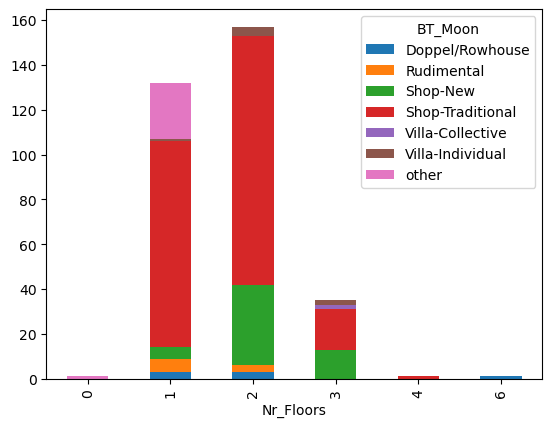

In [293]:
### Distribution of floor numbers
 
geoinformations.groupby(["BT_Moon", "Nr_Floors"])\
       .size()\
       .unstack(0)\
       .plot.bar(stacked=True)

#plt.hist(stacked=True)

#### Join adresses
Add geolocations and building information based on common street and house numbers to the survey dataset in vietnamese language

In [278]:
geoinformations["Street"].sort_values().unique()
#.isin(vietnamese_data["street"] )


array(['Bình Quới', 'Duong so 1', 'Duong so 2', 'Duong so 6',
       'Hoàng Ngân', 'Hồ Học Lãm', 'Kinh Dương', 'Lê Thành P',
       'Lê Văn Lươ', 'Mai Hắc Đế', 'Mễ Cốc', 'Nhơn Đức', 'Phú Định',
       'Sinco', 'Điện Biên', 'Đào Sư Tíc', nan], dtype=object)

In [279]:
vietnamese_data["street"].sort_values().unique()

## TODO make all as small letter due to typo mix of capital and small letters
## TODO match also if onyl first letters are matched 
# eg. 'Lê Thành P' <-> 'Lê Thành Phương' or "Lê Văn Lươ" <-> 'Lê Văn Lương', "Sinco" <-> 
## TODO filter in veit_data for steets with 'Đường số' and 1 , 2, 6

array(['* Mễ Cốc', 'A Bình Quới', 'A Bến Phú Định', 'A Hồ Học Lãm',
       'A Lê Văn Lương', 'A Lê Văn Lương ấp', 'A Lưu Hữu Phước',
       'A Lạch Cát', 'A Mai Hắc Đế', 'A Mễ Cốc', 'A Nhơn Đức',
       'A Phú Định', 'A Rạch Cát', 'A hẻm  Đào Sư Tích',
       'A Điện Biên Phủ', 'A Đào Sư Tích', 'A Ấp', 'B Bình Đức',
       'B Kinh Dương Vương', 'B Lê Thành Phương', 'B Lê Văn Lương',
       'B Nhơn Đức', 'B ấp', 'Bis Lê Thành Phương', 'Bình Quới',
       'Bình Qưới', 'Bình Đức', 'Bến Phú Định', 'C', 'C Mễ Cốc',
       'C Phú Định', 'D Bình Đức', 'D Sinco', 'H Lê Văn Lương',
       'Hoàng Ngân', 'Hồ Học Lãm', 'Hồ Học lãm', 'Hồ Ngọc Lãm',
       'KP Kinh Dương Vương', 'KYTKTC', 'Kinh Dương Vương',
       'Lê Thành Phương', 'Lê Tấn Bê', 'Lê Văn Lương', 'Lê Văn Lương ấp',
       'Lưu Hữu Phước', 'Mai Hắc Đế', 'Mễ Cốc', 'Nguyễn Bình', 'Nhơn Đức',
       'Phú Định', 'QLA', 'Quốc Lộ A', 'S Điện Biên Phủ', 'Sen co',
       'Sinco', 'Số  đường số  khu phố', 'Tổ  Điện Biên Phủ',
       'khu YTKT 

In [303]:
## First join: if street name and house number matches
vietnamese_data_geolocations = vietnamese_data.merge(
    geoinformations,
    #[
    #     geoinformations[["Street"]].isin(vietnamese_data[["street"]])
    #   #  geoinformations[["Street", "HouseNumbe"]].isin(vietnamese_data[["street", "house_number"]])
    #    ], 
    right_on=["Street"],#, "HouseNumbe"],
    left_on=["street"]#, "house_number"]
)

print(vietnamese_data_geolocations.shape)
vietnamese_data_geolocations

(2089, 565)


,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2